So what we want to do really is to extract the inputs and the targets, basically like the labels and the MFCCs from the music dataset and store that in a JSON file so that then we can use it when we actuall train our neural network.

#### [**Dataset Source Link**](http://marsyas.info/downloads/datasets.html)

## Step 1:- Get Data

In [ ]:
!wget https://www.dropbox.com/sh/tdb2xjmotjk6uow/AAAzxn9iv4Cc2MvRrFrujhxha?dl=0

--2021-08-19 17:51:51--  https://www.dropbox.com/sh/tdb2xjmotjk6uow/AAAzxn9iv4Cc2MvRrFrujhxha?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/tdb2xjmotjk6uow/AAAzxn9iv4Cc2MvRrFrujhxha [following]
--2021-08-19 17:51:52--  https://www.dropbox.com/sh/raw/tdb2xjmotjk6uow/AAAzxn9iv4Cc2MvRrFrujhxha
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca6192895d9caebd81fb5d466ff.dl.dropboxusercontent.com/zip_download_get/A36B-vS320DNr880DRvXpaNUOUrIjaQK6SiB3JvNdAJCHpuFwSjfG3k5Cyo1fRyxp0xzVoioH4TRmtFI8MXcn5Ow7xMaw9sUwZweQpJsoep6CQ# [following]
--2021-08-19 17:51:53--  https://uca6192895d9caebd81fb5d466ff.dl.dropboxusercontent.com/zip_download_get/A36B-vS320DNr880DRvXpaNUOUrIjaQK6SiB3JvNdAJCHpuFwSjfG3k5Cyo1fRyxp0xzVoioH4TRm

In [ ]:
!unzip AAAzxn9iv4Cc2MvRrFrujhxha?dl=0

Archive:  AAAzxn9iv4Cc2MvRrFrujhxha?dl=0
mapname:  conversion of  failed
   creating: genres/
   creating: genres/pop/
   creating: genres/rock/
   creating: genres/jazz/
   creating: genres/metal/
   creating: genres/blues/
 extracting: genres/ro.mf            
 extracting: genres/hi.mf            
 extracting: genres/cl.mf            
 extracting: genres/re.mf            
 extracting: genres/bl.mf            
 extracting: genres/po.mf            
 extracting: genres/ja.mf            
 extracting: genres/co.mf            
   creating: genres/disco/
 extracting: genres/di.mf            
 extracting: genres/me.mf            
   creating: genres/reggae/
   creating: genres/hiphop/
   creating: genres/country/
 extracting: genres/input.mf         
   creating: genres/classical/
 extracting: genres/pop/pop.00034.wav  
 extracting: genres/pop/pop.00098.wav  
 extracting: genres/pop/pop.00041.wav  
 extracting: genres/pop/pop.00006.wav  
 extracting: genres/pop/pop.00021.wav  
 extracting: g

## Step 2:- Preprocess Data

In [ ]:
import os
import librosa
import math
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [ ]:
DATASET_PATH = "/content/genres"
JSON_PATH = "/content/data.json"
SAMPLE_RATE = 22050
DURATION = 30 # measured in seconds(GIVEN)
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [ ]:
def save_mfcc(dataset_path,json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5): # num_segments are basically used to to increase the data, as we just have 100 wav files for each genre which is not sufficient 
  # dictionary to store data
  data = { 
      "mapping": [], # we need a way of mapping different genres to like genre labels onto numbers
      "mfcc": [], # mfcc vectors for each of the segments for ex. suppose we have 3 segments then our mfcc vector will look something like [[...][...][...]]
      "labels": [] # mfcc's itself are the training inputs , where as the labels are the ouputs or the targets we expect
  }
  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length) # rememeber that we calculate the MFCC per hop length (ceil(1.2)->2)

  # loop through all the genres
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)): # remember we also need the count here t ofill it in our dictionary
    
    # ensure that we're not at the root level
    if dirpath is not dataset_path:
      # save the semantic labels
      dirpath_components = dirpath.split("/")
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      print(f"\nProcessing {semantic_label}")


      # process files for a specific genre
      for f in filenames:
        # we do this because we want to load the audio file
        file_path = os.path.join(dirpath,f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # process segments extracting mfcc and storing data
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s # s-> which is like the current segment we are in, for example for the first segment ie for s=0 -> 0
          finish_sample = start_sample + num_samples_per_segment # finished sample for s=0 will be num_samples_per_segment

          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
          mfcc = mfcc.T

          # So we store mfcc for segment if it has the expected length
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
            print(f"{file_path}, segment:{s+1}")
  with open(json_path,"w") as fp:
    json.dump(data, fp, indent=4)

Sometimes we face a problem like the audio files don't have the expected number of samples , like duration of audio files might be slightly less or more in comparison to other audio files, which basically means thet when we do mfcc , we may have more or less vectors then expected and we don't want to include those in our dataset, because when we pass like these MFCCs as the training data , we need for like the training data to have all the same shape, and we need to ensure that we have like the same number of MFCCs vecors for each segment.

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/genres/classical/classical.00056.wav, segment:7
/content/genres/classical/classical.00056.wav, segment:8
/content/genres/classical/classical.00056.wav, segment:9
/content/genres/classical/classical.00056.wav, segment:10
/content/genres/classical/classical.00078.wav, segment:1
/content/genres/classical/classical.00078.wav, segment:2
/content/genres/classical/classical.00078.wav, segment:3
/content/genres/classical/classical.00078.wav, segment:4
/content/genres/classical/classical.00078.wav, segment:5
/content/genres/classical/classical.00078.wav, segment:6
/content/genres/classical/classical.00078.wav, segment:7
/content/genres/classical/classical.00078.wav, segment:8
/content/genres/classical/classical.00078.wav, segment:9
/content/genres/classical/classical.00078.wav, segment:10
/content/genres/classical/classical.00027.wav, segment:1
/content/genres/classical/classical.00027.wav, segment:2
/content/genres/classical/classical

In [ ]:
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)): # remember we also need the count here t ofill it in our dictionary
    print(i)
    dirpath_components = dirpath.split("/")
    print(dirpath_components)
    print(dirnames)
    print(filenames)
    print("\n")

In [ ]:
for i, j in enumerate(range(5)):
  print(i)
  print(j)
  print("/n")

# Implementing Neural network for Music Genre Classification

Specifically what we are doing today is called Multiclass Classification.

Step 1:- Load Data

In [ ]:
MFCC_DATASET_PATH = '/content/data.json'

In [ ]:
def load_data(dataset_path):
  with open(dataset_path,"r") as fp:
    data = json.load(fp)
  
  # convert lists into numpy arrays
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs,targets

In [ ]:
def plot_history(history):
  fig, axs = plt.subplots(2)

  # create accuracy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].set_xlabel("Epoch")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy Evaluation")

  # create error/loss subplot
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error Evaluation")

  plt.show()

In [ ]:
inputs,targets = load_data(MFCC_DATASET_PATH)

Step 2:- Split the Data into Train and Test

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)

In [ ]:
inputs.shape

(9996, 130, 13)

In [ ]:
inputs_train.shape # the first dimension ie 6997 is given by the segments the dimension 130 is given by the intervals, and the dimension 13 is given by the mfccs for each of the interval, and in our case we have 13 mfccs

(6997, 130, 13)

In [ ]:
model = keras.Sequential([
                          # input layer
                          keras.layers.Flatten(input_shape = (inputs_train.shape[1], inputs_train.shape[2])),

                          # 1st hidden layer
                          keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)), # l2 take a parameter , like in our case it took 0.001, it is basically called as `lambda` and it basically is a `penalty multiplier`
                          keras.layers.Dropout(0.3), # 30% dropout

                          # 2nd Hidden Layer
                          keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
                          keras.layers.Dropout(0.3), # 30% dropout

                          # 3rd Hidden Layer
                          keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
                          keras.layers.Dropout(0.3), # 30% dropout

                          # Output Layers
                          keras.layers.Dense(10, activation="softmax")

])

Step 3:- Compile Network

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # loss -> which loss function we want to use , or error function we want to use

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

Step 4:- Train Network


In [ ]:
history = model.fit(inputs_train, targets_train, validation_data=(inputs_test, targets_test),epochs=100, batch_size=32)

Epoch 1/100
219/219 [==============================] - 2s 7ms/step - loss: 25.6210 - accuracy: 0.1722 - val_loss: 3.9578 - val_accuracy: 0.2834
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 7.6762 - accuracy: 0.1964 - val_loss: 3.3161 - val_accuracy: 0.2874
Epoch 3/100
219/219 [==============================] - 1s 6ms/step - loss: 4.9898 - accuracy: 0.2122 - val_loss: 3.2173 - val_accuracy: 0.2928
Epoch 4/100
219/219 [==============================] - 1s 6ms/step - loss: 4.2122 - accuracy: 0.2164 - val_loss: 3.2044 - val_accuracy: 0.2881
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 3.7990 - accuracy: 0.2262 - val_loss: 3.1623 - val_accuracy: 0.2921
Epoch 6/100
219/219 [==============================] - 1s 6ms/step - loss: 3.6201 - accuracy: 0.2367 - val_loss: 3.1797 - val_accuracy: 0.3021
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 3.4603 - accuracy: 0.2441 - val_loss: 3.1689 - val_accuracy: 0.291

### Plot accuracy and the error over the epochs

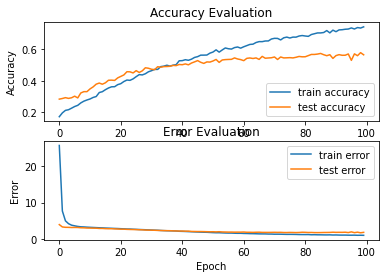

In [ ]:
plot_history(history)